In [33]:
from keras import models
from keras.models import Sequential
from keras.models import Model
from keras.models import load_model
from keras import backend as K

from keras import layers
from keras.layers import Layer
from keras.layers import Input,Dense,Flatten,Embedding,Permute,Dot,Reshape
from keras.layers.convolutional import Conv1D,MaxPooling1D,MaxPooling2D
from keras.layers import Dropout
from keras.layers import LSTM,GRU

from keras.preprocessing import sequence
from keras.utils import np_utils

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

import pandas as pd
from pandas import DataFrame, Series
import numpy as np

import re

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

import copy

In [34]:
#토큰화 파일을 불러온다.

rawdata = pd.read_csv("토큰화.csv",engine="python",encoding = "cp949")

morphs = list()

for i in range(0,len(rawdata)):
    morphs.append(list(rawdata.loc[i,:].dropna()))

del morphs[0]

In [35]:
#색인 사전을 불러온다.

morphsVectored = list()


vocabulary = pd.read_csv("색인사전.csv",engine="python",encoding="cp949")
#del vocabulary["Unnamed: 0"]

vocabulary = vocabulary.to_dict(orient="records")[0]

In [36]:
#원본 데이터셋을 불러온다.

a = pd.read_csv("beer.csv",engine="python",encoding="cp949")
a = a[a["reviews"].duplicated() == False]
a = a.reset_index()
del a["index"]

#타겟과 텍스트를 따로 저장한다.
target = a["target"]
text= a["reviews"]

a.head()

,reviews,source,target
0,98년생들에게 추천하는 맛있는 맥주 \n\n1. 브르클린 라거\n2. 펑크 IPA\...,twitter,듀벨
1,퇴근 후 아내가 차려준 주안상과 함께하는 듀벨~\n\n#beer #belgian #...,twitter,듀벨
2,.\n오랜만에 새로운 맥주 입고!\n개인적으로 가장 좋아하는 #IPA #스컬핀 뉴시...,twitter,듀벨
3,스타ㅏㅏㅏ듀벨ㄹㄹ리이ㅣ이ㅣㅣ이ㅣㅣㅣ!!!!!!!!!~!~~!~!~!~!~!~!~!!...,twitter,듀벨
4,듀벨 트리플홉 2017이 입고됐습니다. 듀벨은 매년 기존 두 가지 홉 외에 하나를 ...,twitter,듀벨


In [37]:
#로드한 토큰화 파일에서, 색인사전을 검색하여 토큰화 문장을 숫자 문장으로 바꿔준다.

for i in morphs:
    temporailyList = list()
    for k in i:
        #print(k)
        try:
            temporailyList.append(vocabulary[k])
        except KeyError:
            temporailyList.append(0)
    morphsVectored.append(temporailyList)

In [38]:
target.unique()

array(['듀벨', '기네스', '버드와이저', '베를리너필스너', '블랑', '산미구엘', '삿포로', '스텔라', '아사히',
       '칭따오', '카스', '칼스버그', '코로나', '코젤', '크롬바커', '필스너우르켈', '하이네켄', '하이트',
       '베를리너', '헤페', '호가든', '삿포로맥주', '아사히맥주', '칭따오맥주', '필라이트', '필스너'],
      dtype=object)

## EDA

In [39]:
print(len(morphs),len(morphsVectored))

67316 67316


In [8]:
## 윈도우 길이 탐색

length = DataFrame()

for i,j in enumerate(morphs):
    good = DataFrame([len(j)],index=[i])
    length = pd.concat([length,good],axis=0)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000168390114A8>]],
      dtype=object)

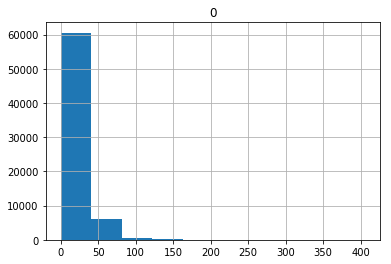

In [11]:
#오리지널
length.hist()

22


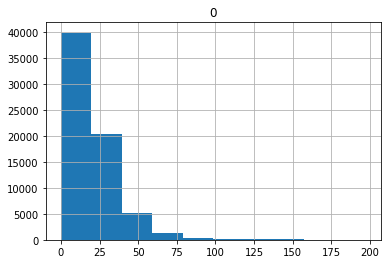

In [12]:
#첫 번째 트라이얼
#해당 길이에서 자르면서 버려지는 문장의 수

# 200개 이하 문장만 봤을때의 히스토그램

length_cut = length[length[0]<200]

length_cut.hist()

print(len(length[length[0]>200]))

498


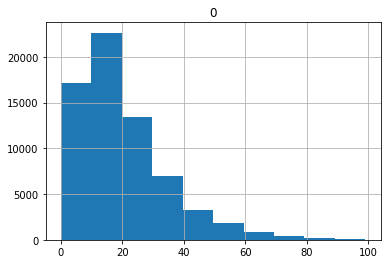

In [13]:
#첫 번째 트라이얼
#해당 길이에서 자르면서 버려지는 문장의 수

# 200개 이하 문장만 봤을때의 히스토그램

length_cut = length[length[0]<100]

length_cut.hist()

print(len(length[length[0]>100]))

1946


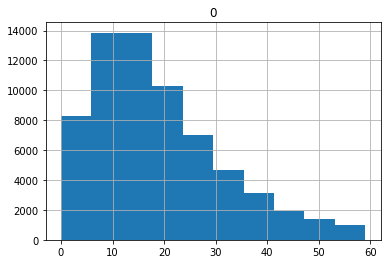

In [18]:
#첫 번째 트라이얼
#해당 길이에서 자르면서 버려지는 문장의 수

# 200개 이하 문장만 봤을때의 히스토그램

length_cut = length[length[0]<60]

length_cut.hist()

print(len(length[length[0]>60]))

In [9]:
length_cut = length[length[0]<60]
morphsVectored = Series(morphsVectored)[length_cut.index].tolist()

In [10]:
len(morphsVectored)

65076

In [43]:
a = 0
b = 0

for i in range(0,len(morphs)):
    a += len(morphs[i])

mu = a/len(morphs)

for i in range(0, len(morphs)):
    b += ((len(morphs[i]) - mu)**2)
    #print(b)

std_dev = (b/len(morphs))**0.5

print(mu,std_dev)

size= mu + (std_dev*2)

20.730732663854063 17.980981453857844


In [40]:
#토큰화 문장에서 맥주 키워드(듀벨, 기네스, 카스 ,하이트 등등)을 제거한다.

preprocessing_target_from_target = target.unique()

for j,i in enumerate(morphs):
    for k in preprocessing_target_from_target:
        for l in np.where(np.array(i) == k)[0]:
            try:
                del morphs[j][l]
            except IndexError : 
                pass

C:\Users\User\Anaconda3\envs\tensorflow36\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys


In [41]:
vectorized_seq = sequence.pad_sequences(morphsVectored,maxlen = 50)

In [46]:
listed = list()
error = list()

for i in target:
    try:
        listed.append(vocabulary[i])
    except : 
        error.append(i)
print(pd.unique(error))

[]


In [10]:
#타겟도 숫자를 맞춰준다.

target = Series(target)[length_cut.index.tolist()]

NameError: name 'length_cut' is not defined

In [43]:
names = re.compile("[맥주]+")

for i,j in target.items():
    if j.endswith("맥주"):
        target[i] = names.sub("",j)
    else : pass

In [44]:
names = re.compile("[베를리너]+")

for i,j in target.items():
    if j.endswith("필스너"):
        target[i] = names.sub("",j)
    else : pass

In [45]:
names = re.compile("[우르켈]+")

for i,j in target.items():
    if j.endswith("우르켈"):
        target[i] = names.sub("",j)
    else : pass

In [47]:
X_train,X_test,y_train,y_test = train_test_split(vectorized_seq, target)

In [49]:
## 타겟 변수 임베딩 버젼

zero_pad_train = np.array([[0,vocabulary[i]] for i in y_train])
zero_pad_test = np.array([[0,vocabulary[i]] for i in y_test])

In [50]:
zero_pad_train

array([[    0, 48647],
       [    0, 49981],
       [    0, 48863],
       ...,
       [    0, 45334],
       [    0, 48863],
       [    0, 33308]], dtype=int64)

In [51]:
print(len(zero_pad_train),len(y_train))

50487 50487


In [52]:
#타겟 인코딩

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [53]:
a = le.inverse_transform(y_train)

pd.unique(y_train)

pd.unique(a)

target_dict = {i:j for i,j in zip(pd.unique(y_train),pd.unique(a))}

In [54]:
y_train = np.array([[i,i]for i in y_train])
y_test = np.array([[i,i]for i in y_test])

In [55]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [56]:
#y_train = y_train[:,np.newaxis,:]
#y_test = y_test[:,np.newaxis,:]

In [57]:
y_train

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

In [58]:
Series(target_dict).sort_index().to_csv("타겟.csv",encoding="cp949")

# 모델 적합

### 신 BI-GRU with attention 모델

In [59]:
#tf.reset_default_graph

## GRU 입력 전 사전처리 모듈(임베딩 -> 컨볼루션 -> 맥스풀링)

inputs = layers.Input(shape=[50],name = "Feed_Sentence")

embed = layers.Embedding(len(vocabulary)+1,128)

embed_i = embed(inputs)
model = layers.Dropout(0.2)(embed_i)
model = layers.Conv1D(256,3,padding="valid",activation="relu",strides=1)(model)
model = layers.MaxPooling1D(pool_size = 4)(model)

inputs_d = layers.Input(shape = [2],name = "Feed_ZeroPad_for_Decoder")
embed_o = embed(inputs_d)
#embed_o = layers.Concatenate(axis=-1,name="embed_o_Doubled")([embed_o,embed_o])


#Bi-GRU 인코더 - 디코더 네트워크
Encoder1 = layers.GRU(128,return_sequences = True,return_state = True,name="Encoder1")
Encoder2 = layers.GRU(128,return_sequences = True,return_state = True,go_backwards = True,name="Encoder2")
attention_matrix1,initial_1 = Encoder1(model)
attention_matrix2,initial_2 = Encoder2(model)
attention_matrix = layers.Concatenate(axis=-1,name = "attention_matrix")([attention_matrix1,attention_matrix2])


Decoder1 = layers.GRU(128,return_sequences = True,name="Decoder1")
Decoder2 = layers.GRU(128,return_sequences = True,name="Decoder2")
Decoder1_output = Decoder1(embed_o,initial_state = initial_1)
Decoder2_output = Decoder2(embed_o,initial_state = initial_2)
Decoder_output = layers.Concatenate(axis=-1,name="Decoder_output")([Decoder1_output,Decoder2_output])


##어텐션 메커니즘 부분

#normalize = True로 켠 상태에서, 코싸인 유사도를 구할 수 있도록 둘을 내적한다.  
Cosine_similarity = layers.dot([Decoder_output,attention_matrix],axes = -1,normalize=True,name="Cosine_similarity")

#유사도 벡터를 softmax층에 통과시켜 총합이 1인 확률로 변환한다. 이를 attention_score로 명명한다.
attention_score_layer = layers.Softmax(axis=-1,name="attention_score_from_Softmax") 
attention_score = attention_score_layer(Cosine_similarity)

#Softmax 변환된 attention_score를 최초의 attention_matrix와 각각 내적한다.
#Transpose_attention_matrix = layers.Permute((2,1),name = "Transpose_attention_matrix")(attention_matrix)
weighted_attention_matrix = layers.Lambda(lambda x: K.dot(x[0],x[1]),name="weighted_attention_matrix")([attention_score,attention_matrix])
#weighted_attention_matrix = layers.multiply([attention_score,Transpose_attention_matrix],name="weighted_attention_matrix")

#확률과 내적한 가중 attention_matrix의 열벡터를 모두 더해 1D 텐서인 context vector를 만들어준다.(1 * 256)
context_vector = layers.Lambda(lambda x: K.sum(x, axis=2),name="Making_context_vector")(weighted_attention_matrix)
#context_vector_reshape = layers.Reshape((1,-1),name="Reshape_to_3D_tensor")(context_vector)

concat = layers.Concatenate(axis=-1,name = "Concatenate_Decoder_O_and_Context_Vector")([Decoder_output,context_vector])

Feed_forward = layers.Dense(512,activation = "tanh",name="Feed_forward")
finally_output = Feed_forward(concat)

predicts = layers.Dense(22,activation="softmax")(finally_output)

GRUs = Model(inputs = [inputs,inputs_d], outputs = [predicts])
GRUs.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Feed_ZeroPad_for_Decoder (Input (None, 2)            0                                            
__________________________________________________________________________________________________
Feed_Sentence (InputLayer)      (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         multiple             6537344     Feed_Sentence[0][0]              
                                                                 Feed_ZeroPad_for_Decoder[0][0]   
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 50, 128)      0           embedding_2[0][0]                
__________

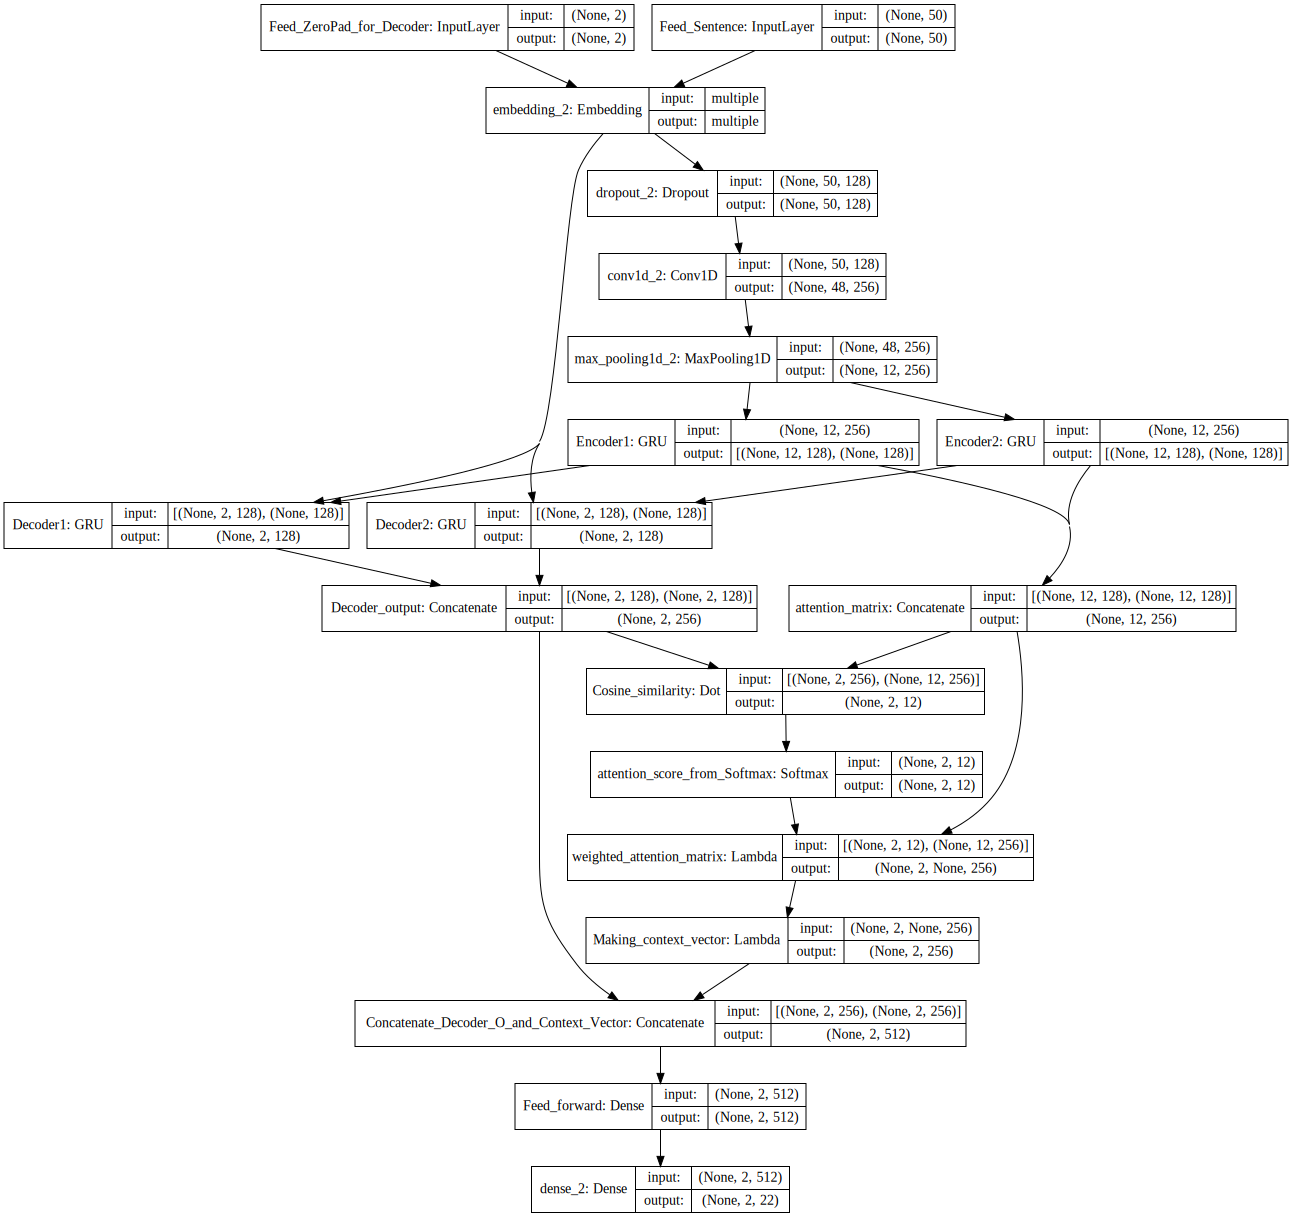

In [60]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model

SVG(model_to_dot(GRUs,show_shapes=True).create(prog="dot",format="svg"))
#plot_model(GRUs, to_file='model.png',show_shapes = True)

In [61]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience = 3)

In [62]:
GRUs.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

In [63]:
GRUs.fit([X_train,zero_pad_train],y_train,epochs=10,batch_size = 64,validation_data = ([X_test,zero_pad_test],y_test),callbacks = [early_stopping])

Train on 50487 samples, validate on 16829 samples
Epoch 1/10
50487/50487 [==============================] - 114s 2ms/step - loss: 0.9433 - acc: 0.7180 - val_loss: 0.5579 - val_acc: 0.8228
Epoch 2/10
50487/50487 [==============================] - 110s 2ms/step - loss: 0.4700 - acc: 0.8511 - val_loss: 0.5446 - val_acc: 0.8306
Epoch 3/10
50487/50487 [==============================] - 110s 2ms/step - loss: 0.3586 - acc: 0.8844 - val_loss: 0.5963 - val_acc: 0.8300
Epoch 4/10
50487/50487 [==============================] - 110s 2ms/step - loss: 0.2777 - acc: 0.9106 - val_loss: 0.6944 - val_acc: 0.8227
Epoch 5/10
50487/50487 [==============================] - 110s 2ms/step - loss: 0.2203 - acc: 0.9293 - val_loss: 0.7551 - val_acc: 0.8224


In [64]:
GRUs.save("chatbot-attention_weight.h5")

C:\Users\User\Anaconda3\envs\tensorflow36\lib\site-packages\keras\engine\network.py:877: UserWarning: Layer Decoder1 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'Encoder1_1/while/Exit_3:0' shape=(?, 128) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
C:\Users\User\Anaconda3\envs\tensorflow36\lib\site-packages\keras\engine\network.py:877: UserWarning: Layer Decoder2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'Encoder2_1/while/Exit_3:0' shape=(?, 128) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


### 구 LSTM 모델

In [188]:
model = Sequential()
model.add(Embedding(len(vocabulary)+1,128,input_length = 50))
model.add(Dropout(0.2))
model.add(Conv1D(256,3,padding="valid",activation="relu",strides=1))
model.add(MaxPooling1D(pool_size = 4))
model.add(LSTM(128))
model.add(Dense(22,activation="softmax"))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 50, 128)           6537344   
_________________________________________________________________
dropout_12 (Dropout)         (None, 50, 128)           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 48, 256)           98560     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 12, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_12 (Dense)             (None, 22)                2838      
Total params: 6,835,862
Trainable params: 6,835,862
Non-trainable params: 0
_________________________________________________________________


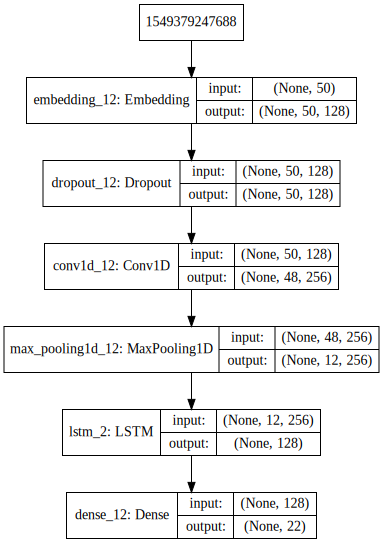

In [189]:
model.summary()
SVG(model_to_dot(model,show_shapes=True).create(prog="dot",format="svg"))

In [191]:
model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

model.fit(X_train,y_train,epochs=5,batch_size = 64,validation_data = (X_test,y_test),callbacks = [early_stopping])

Train on 48965 samples, validate on 16322 samples
Epoch 1/20
48965/48965 [==============================] - 104s 2ms/step - loss: 2.1092 - acc: 0.3308 - val_loss: 1.7512 - val_acc: 0.4491
Epoch 2/20
48965/48965 [==============================] - 99s 2ms/step - loss: 1.4777 - acc: 0.5322 - val_loss: 1.7299 - val_acc: 0.4620
Epoch 3/20
48965/48965 [==============================] - 100s 2ms/step - loss: 1.0914 - acc: 0.6575 - val_loss: 1.8994 - val_acc: 0.4588
Epoch 4/20
48965/48965 [==============================] - 100s 2ms/step - loss: 0.8051 - acc: 0.7453 - val_loss: 2.1059 - val_acc: 0.4551
Epoch 5/20
48965/48965 [==============================] - 100s 2ms/step - loss: 0.6206 - acc: 0.8029 - val_loss: 2.3438 - val_acc: 0.4458
